In [1]:
import sys

sys.path = [p for p in sys.path if 'vast-1.4.2' not in p]
sys.path.insert(0, '/global/u2/z/ziqi/.local/lib/python3.9/site-packages/vast-1.6.1-py3.9-linux-x86_64.egg')

import vast
print("VAST imported successfully.")
print("Python executable:", sys.executable)
print("Python version:", sys.version)
print("VAST version:", vast.__version__)


VAST imported successfully.
Python executable: /global/homes/z/ziqi/python3.9/bin/python3.9
Python version: 3.9.9 (main, Nov 15 2024, 02:35:40) 
[GCC 12.3.0]
VAST version: 1.6.1


In [2]:
import os
import numpy as np

from astropy.table import QTable, Table
import fitsio
import pickle

from vast.catalog import void_catalog as vc
from vast.catalog.void_catalog import VoidFinderCatalogStacked

from vast.voidfinder import vflag
from vast.voidfinder import find_voids, filter_galaxies
from vast.voidfinder.multizmask import generate_mask
from vast.voidfinder.preprocessing import file_preprocess
from vast.voidfinder.vflag import determine_vflag
from vast.voidfinder.distance import z_to_comoving_dist
from vast.voidfinder import ra_dec_to_xyz
#from vast.voidfinder.postprocessing import open_fits_file

from scipy.special import logsumexp, betaln, gammaln
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy import conf
from astropy.table import Table

# Filter according to RA, DEC, and strip

In [3]:
galaxy_file = "filtered_data.fits"
galaxies = Table.read(galaxy_file, format='fits')
print(galaxies.colnames)


ra_boolean = np.logical_and(galaxies['RA'] > 110, galaxies['RA'] < 270)
catalog_north = galaxies[ra_boolean]
print(f"number of galaxies in RA(110, 270)：{len(catalog_north)}")

'''
strip_boolean = np.logical_and.reduce([
    catalog_north['RA'] > 250, 
    catalog_north['RA'] < 269, 
    catalog_north['DEC'] > 51, 
    catalog_north['DEC'] < 67
])
catalog_main = catalog_north[~strip_boolean]

print(f"number of galaxies after removing strips：{len(catalog_main)}")
'''

output_file = "filtered_data_main.fits"
catalog_north.write(output_file, format='fits', overwrite=True)
print(f"save result to：{output_file}")



['Z', 'DEC', 'RA', 'ABS_MAG_R', 'ABS_MAG_U', 'ABS_MAG_G', 'LOG_MSTAR', 'HALPHA', 'HBETA', 'SFR', 'APP_MAG', 'FIBER_FLUX_G', 'FIBER_FLUX_R', 'FIBER_FLUX_Z', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'Color_ur', 'Color_gr', 'Halpha_EW']
number of galaxies in RA(110, 270)：2441885
save result to：filtered_data_main.fits


# Classify Galaxies

In [4]:

################################################################################
# USER INPUT
#-------------------------------------------------------------------------------
ngc_file = 'DESIVAST_NGC_VoidFinder_Output.fits'
sgc_file = 'DESIVAST_SGC_VoidFinder_Output.fits'
galaxy_file = "filtered_data_main.fits"

dist_metric = 'comoving'
Omega_M = 0.26
h = 1
DtoR = np.pi / 180
################################################################################


################################################################################
# IMPORT AND PREPARE GALAXY DATA
#-------------------------------------------------------------------------------
print('Importing galaxy data to be classified')

# Read in the FITS file for galaxies to be classified
galaxies = Table.read(galaxy_file, format='fits')

# Rename columns to standard names
galaxies['ra'] = galaxies['RA']
galaxies['dec'] = galaxies['DEC']
galaxies['redshift'] = galaxies['Z']


print('Galaxy data imported')
################################################################################


################################################################################
# IMPORT VOID CATALOG AND MASK (NGC)
#-------------------------------------------------------------------------------
print('Importing NGC void data and mask')

with fits.open(ngc_file) as hdul_ngc:
    primary_header_ngc = hdul_ngc[0].header
    dist_limits_ngc = [primary_header_ngc['DLIML'], primary_header_ngc['DLIMU']]
    mask_ngc = hdul_ngc[1].data
    mask_resolution_ngc = hdul_ngc[1].header['MSKRES']
    voids_ngc = hdul_ngc['HOLES'].data

print('NGC void data and mask imported')
################################################################################



Importing galaxy data to be classified
Galaxy data imported
Importing NGC void data and mask
NGC void data and mask imported


In [5]:
################################################################################
# CONVERT GALAXY ra, dec, z TO x, y, z COORDINATES
#-------------------------------------------------------------------------------
print('Converting coordinate system')

# Convert redshift to distance
if dist_metric == 'comoving':
    if 'Rgal' not in galaxies.columns:
        galaxies['Rgal'] = z_to_comoving_dist(galaxies['redshift'].data.astype(np.float32), Omega_M, h)
    galaxies_r = galaxies['Rgal']
else:
    c = 3e5  # km/s
    H = 100 * h
    galaxies_r = c * galaxies['redshift'] / H


galaxies_x = galaxies_r * np.cos(galaxies['dec'] * DtoR) * np.cos(galaxies['ra'] * DtoR)
galaxies_y = galaxies_r * np.cos(galaxies['dec'] * DtoR) * np.sin(galaxies['ra'] * DtoR)
galaxies_z = galaxies_r * np.sin(galaxies['dec'] * DtoR)

print('Coordinates converted')
################################################################################



Converting coordinate system
Coordinates converted


In [6]:
################################################################################
# IDENTIFY LARGE-SCALE ENVIRONMENT (NGC)
#-------------------------------------------------------------------------------
print('Identifying environment in NGC')

galaxies['vflag'] = -9  # Initialize vflag column for NGC

# Iterate over all galaxies to classify for NGC
for i in range(len(galaxies)):
    galaxies['vflag'][i] = determine_vflag(
        galaxies_x[i], 
        galaxies_y[i], 
        galaxies_z[i], 
        voids_ngc, 
        mask_ngc, 
        mask_resolution_ngc, 
        dist_limits_ngc[0], 
        dist_limits_ngc[1]
    )
    if (i + 1) % 50000 == 0:
        print(f'Processed {i + 1} galaxies out of {len(galaxies)}')

print('NGC environments identified')
################################################################################


Identifying environment in NGC
Processed 50000 galaxies out of 2441885
Processed 100000 galaxies out of 2441885
Processed 150000 galaxies out of 2441885
Processed 200000 galaxies out of 2441885
Processed 250000 galaxies out of 2441885
Processed 300000 galaxies out of 2441885
Processed 350000 galaxies out of 2441885
Processed 400000 galaxies out of 2441885
Processed 450000 galaxies out of 2441885
Processed 500000 galaxies out of 2441885
Processed 550000 galaxies out of 2441885
Processed 600000 galaxies out of 2441885
Processed 650000 galaxies out of 2441885
Processed 700000 galaxies out of 2441885
Processed 750000 galaxies out of 2441885
Processed 800000 galaxies out of 2441885
Processed 850000 galaxies out of 2441885
Processed 900000 galaxies out of 2441885
Processed 950000 galaxies out of 2441885
Processed 1000000 galaxies out of 2441885
Processed 1050000 galaxies out of 2441885
Processed 1100000 galaxies out of 2441885
Processed 1150000 galaxies out of 2441885
Processed 1200000 galax

In [7]:
################################################################################
# SAVE RESULTS
#-------------------------------------------------------------------------------
print('Saving classified galaxies')

output_filename = 'classified_galaxies.fits'
galaxies.write(output_filename, format='fits', overwrite=True)

print('Results saved to', output_filename)
print(len(galaxies['vflag']))
################################################################################

Saving classified galaxies
Results saved to classified_galaxies.fits
2441885


In [8]:
#total num of galaxies is 294111

num_wall_galaxies = np.sum(galaxies['vflag'] == 0)
print(f"Wall Galaxies (vflag = 0): {num_wall_galaxies}")

num_void_galaxies = np.sum(galaxies['vflag'] == 1)
print(f"Void Galaxies (vflag = 1): {num_void_galaxies}")

num_wall_galaxies = np.sum(galaxies['vflag'] == 2)
print(f"Edge Galaxies (vflag = 2): {num_wall_galaxies}")

num_void_galaxies = np.sum(galaxies['vflag'] == 9)
print(f"Out Galaxies (vflag = 9): {num_void_galaxies}")


Wall Galaxies (vflag = 0): 491740
Void Galaxies (vflag = 1): 402893
Edge Galaxies (vflag = 2): 308434
Out Galaxies (vflag = 9): 1238818


# Plot

In [9]:
galaxy_file = "classified_galaxies.fits"

galaxies = Table.read(galaxy_file, format='fits')

In [10]:
import matplotlib.pyplot as plt

wall_abs_mag_VF = galaxies['ABS_MAG_R'][galaxies['vflag'] == 0]
wall_log_mstar_VF = galaxies['LOG_MSTAR'][galaxies['vflag'] == 0]
wall_color_ur_VF = galaxies['Color_ur'][galaxies['vflag'] == 0]
wall_color_gr_VF = galaxies['Color_gr'][galaxies['vflag'] == 0]

# Void Galaxies (vflag_combined == 1)
void_abs_mag_VF = galaxies['ABS_MAG_R'][galaxies['vflag'] == 1]
void_log_mstar_VF = galaxies['LOG_MSTAR'][galaxies['vflag'] == 1]
void_color_ur_VF = galaxies['Color_ur'][galaxies['vflag'] == 1]
void_color_gr_VF = galaxies['Color_gr'][galaxies['vflag'] == 1]


print(len(wall_abs_mag_VF),len(void_abs_mag_VF))
print(len( galaxies['ABS_MAG_R'][galaxies['vflag'] == 2]))
print(len( galaxies['ABS_MAG_R'][galaxies['vflag'] == 9]))

491740 402893
308434
1238818


In [11]:
abs_mag_r_total = (
    galaxies['ABS_MAG_R'][galaxies['vflag'] == 0].tolist() + 
    galaxies['ABS_MAG_R'][galaxies['vflag'] == 1].tolist() + 
    galaxies['ABS_MAG_R'][galaxies['vflag'] == 2].tolist()
)
logmstar_total = (
    galaxies['LOG_MSTAR'][galaxies['vflag'] == 0].tolist() + 
    galaxies['LOG_MSTAR'][galaxies['vflag'] == 1].tolist() + 
    galaxies['LOG_MSTAR'][galaxies['vflag'] == 2].tolist()
)
ur_total = (
    galaxies['Color_ur'][galaxies['vflag'] == 0].tolist() + 
    galaxies['Color_ur'][galaxies['vflag'] == 1].tolist() + 
    galaxies['Color_ur'][galaxies['vflag'] == 2].tolist()
)
gr_total = (
    galaxies['Color_gr'][galaxies['vflag'] == 0].tolist() + 
    galaxies['Color_gr'][galaxies['vflag'] == 1].tolist() + 
    galaxies['Color_gr'][galaxies['vflag'] == 2].tolist()
)

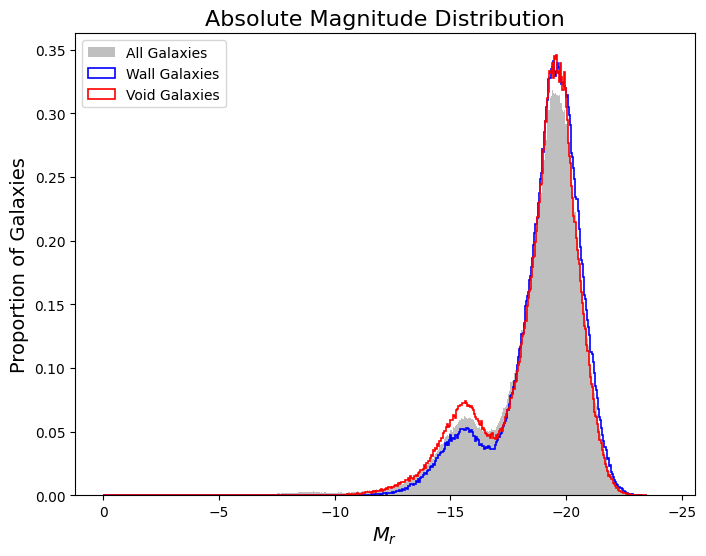

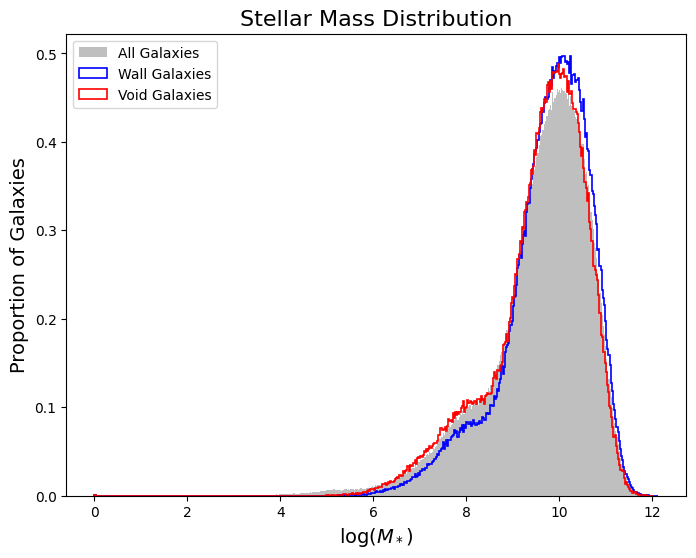

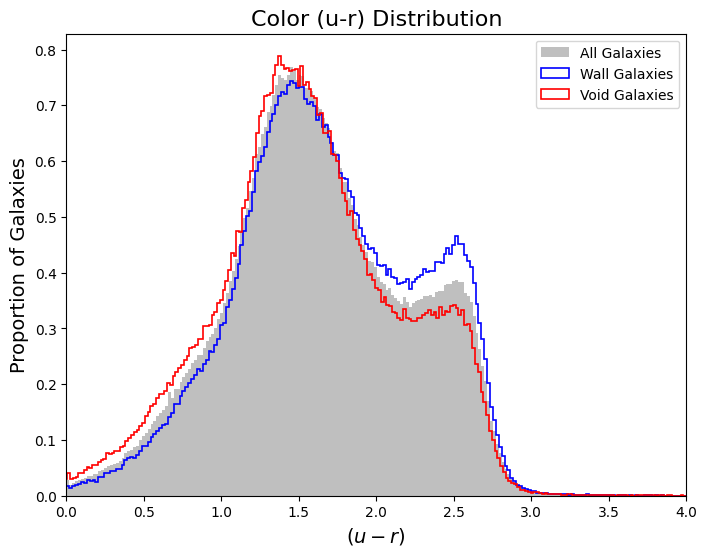

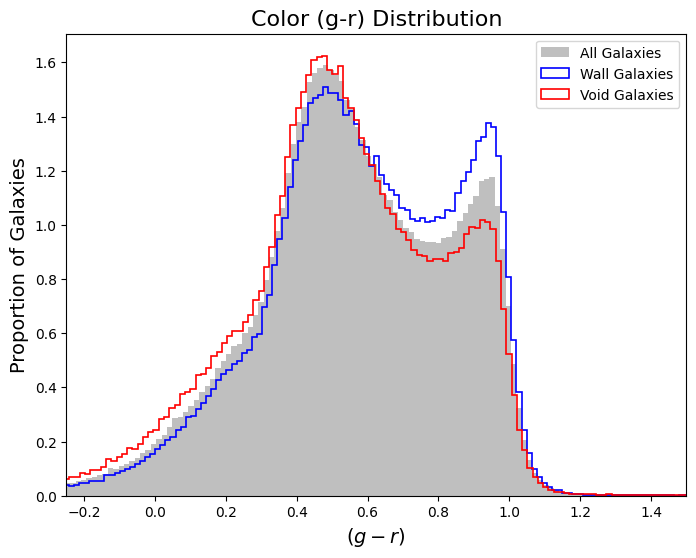

In [16]:

################################################################################
# PLOT HISTOGRAMS FOR EACH PROPERTY
#-------------------------------------------------------------------------------

# 1. Absolute Magnitude (M_r)
plt.figure(figsize=(8, 6))

plt.hist(abs_mag_r_total, bins=500, density=True, alpha=0.5, color='gray', label='All Galaxies')
plt.hist(wall_abs_mag_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='blue', label='Wall Galaxies')
plt.hist(void_abs_mag_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='red', label='Void Galaxies')

plt.xlabel(r"$M_r$", fontsize=14)
plt.ylabel("Proportion of Galaxies", fontsize=14)
plt.title("Absolute Magnitude Distribution", fontsize=16)
plt.legend()
plt.gca().invert_xaxis()
plt.show()


# 2. Stellar Mass (Log M_star)
plt.figure(figsize=(8, 6))
plt.hist(logmstar_total, bins=500, density=True, alpha=0.5, color='gray', label='All Galaxies')
plt.hist(wall_log_mstar_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='blue', label='Wall Galaxies')
plt.hist(void_log_mstar_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='red', label='Void Galaxies')

plt.xlabel(r"$\log(M_*)$", fontsize=14)
plt.ylabel("Proportion of Galaxies", fontsize=14)
plt.title("Stellar Mass Distribution", fontsize=16)
plt.legend()
plt.show()


# 3. Color (u-r)
plt.figure(figsize=(8, 6))
plt.hist(ur_total, bins=500, density=True, alpha=0.5, color='gray', label='All Galaxies')
plt.hist(wall_color_ur_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='blue', label='Wall Galaxies')
plt.hist(void_color_ur_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='red', label='Void Galaxies')
plt.xlim(0,4)
plt.xlabel(r"$(u-r)$", fontsize=14)
plt.ylabel("Proportion of Galaxies", fontsize=14)
plt.title("Color (u-r) Distribution", fontsize=16)
plt.legend()
plt.show()


# 4. Color (g-r)
plt.figure(figsize=(8, 6))
plt.hist(gr_total, bins=500, density=True, alpha=0.5, color='gray', label='All Galaxies')
plt.hist(wall_color_gr_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='blue', label='Wall Galaxies')
plt.hist(void_color_gr_VF, bins=500, density=True, histtype='step', linestyle='solid', linewidth=1.2, color='red', label='Void Galaxies')
plt.xlim(-0.25,1.5)
plt.xlabel(r"$(g-r)$", fontsize=14)
plt.ylabel("Proportion of Galaxies", fontsize=14)
plt.title("Color (g-r) Distribution", fontsize=16)
plt.legend()
plt.show()
################################################################################


# Slice Plot

In [13]:
from vast.catalog.void_catalog import VoidFinderCatalog
from vast.catalog.void_slice_plots import VoidMapVF

In [17]:
from astropy.table import Table

input_file = 'classified_galaxies.fits'
output_file = 'classified_galaxies_modified.fits'

galaxies = Table.read(input_file, format='fits')

print("Original column names:", galaxies.colnames)

if 'ABS_MAG_R' in galaxies.colnames:
    galaxies.rename_column('ABS_MAG_R', 'rmag')
    print("APP_MAG rename as rmag")
else:
    print("Error: 'APP_MAG' doesn't exist")

galaxies.write(output_file, format='fits', overwrite=True)

print(f"save as: {output_file}")


Original column names: ['Z', 'DEC', 'RA', 'ABS_MAG_R', 'ABS_MAG_U', 'ABS_MAG_G', 'LOG_MSTAR', 'HALPHA', 'HBETA', 'SFR', 'APP_MAG', 'FIBER_FLUX_G', 'FIBER_FLUX_R', 'FIBER_FLUX_Z', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'Color_ur', 'Color_gr', 'Halpha_EW', 'ra', 'dec', 'redshift', 'Rgal', 'vflag']
APP_MAG rename as rmag
save as: classified_galaxies_modified.fits


In [18]:
classified_galaxies = Table.read('classified_galaxies_modified.fits', format='fits')

print("Column names in classified_galaxies.fits:")
print(classified_galaxies.colnames)


Column names in classified_galaxies.fits:
['Z', 'DEC', 'RA', 'rmag', 'ABS_MAG_U', 'ABS_MAG_G', 'LOG_MSTAR', 'HALPHA', 'HBETA', 'SFR', 'APP_MAG', 'FIBER_FLUX_G', 'FIBER_FLUX_R', 'FIBER_FLUX_Z', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'Color_ur', 'Color_gr', 'Halpha_EW', 'ra', 'dec', 'redshift', 'Rgal', 'vflag']


In [19]:
ngc_file = 'DESIVAST_NGC_VoidFinder_Output.fits'
galaxy_file = "classified_galaxies_modified.fits"

galaxies = Table.read(galaxy_file, format='fits')

vflag_column = galaxies['vflag']
print(len(vflag_column))

#remove edge buffer
#voidfinder_catalog = VoidFinderCatalog(ngc_file, edge_buffer=0)

voidfinder_catalog = VoidFinderCatalog(ngc_file)
voidfinder_catalog.add_galaxies(galaxy_file)


2441885


In [20]:
voidfinder_catalog.galaxies['rabsmag'] = -30

In [21]:

#voidfinder_catalog.calculate_vflag('ngc_vflags.fits') 
#voidfinder_catalog.calculate_r_eff()  # Effective Void Radii


def redtext(text):
    return f"\x1b[31m{text}\x1b[0m"

print('\n'+redtext("VoidFinder"),'\n')
voidfinder_catalog.void_stats()


VoidFinder 

3246 voids
1881 edge voids
38 near-edge voids
1327 interior voids
68 edge voids (V. Fid)
2 near-edge voids (V. Fid)
860 interior voids (V. Fid)
Mean Reff (V. Fid): 16.53 +/- 0.0554 Mpc/h
Median Reff (V. Fid): 15.73 +/- 0.0695 Mpc/h
Maximum Reff (V. Fid): 31.32 Mpc/h


/tmp/ipykernel_2071326/1331811719.py:9: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  voidfinder_catalog.void_stats()


In [22]:
print(voidfinder_catalog.maximals["ra","dec"][:5])
voidfinder_catalog.galaxies[:5]

        ra                dec        
------------------ ------------------
 192.0918608937389 -7.617182432036663
237.73575505720598   8.12007895388944
256.47295103438404 14.213058577945016
250.32849317150055  4.423619087144855
172.33831693615068 -6.864174636878769


Z,DEC,RA,rmag,ABS_MAG_U,ABS_MAG_G,LOG_MSTAR,HALPHA,HBETA,SFR,APP_MAG,FIBER_FLUX_G,FIBER_FLUX_R,FIBER_FLUX_Z,FLUX_G,FLUX_R,FLUX_Z,Color_ur,Color_gr,Halpha_EW,ra,dec,redshift,Rgal,vflag,gal,x,y,z,rabsmag
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,float32,float32,float32,int64
0.079203255,50.303135,223.77232,-13.243707,-12.682283,-13.205045,6.1614137,0.2997782,0.46918648,0.0010844236,23.635614,0.25488245,0.11517216,0.23496702,0.34314245,0.15262952,0.30698594,0.5614233,0.038661957,7.045065,223.77232,50.303135,0.079203255,232.94093,9,0,-107.43709,-102.92889,179.23279,-30
0.13082136,50.309654,224.05397,-14.862446,-14.653362,-14.844952,8.250556,30.021084,11.223173,0.038587797,23.106554,0.3901507,0.40353453,0.50016147,0.52525723,0.5348143,0.65354687,0.20908356,0.017494202,245.51242,224.05397,50.309654,0.13082136,379.81662,9,1,-174.32812,-168.66435,292.2716,-30
0.215545,50.48122,165.1956,-15.717111,-13.815876,-14.9996805,7.632881,0.53165114,0.0868789,0.43308824,23.336185,0.12275391,0.30725098,0.23448275,0.16468282,0.40667808,0.30660638,1.9012346,0.7174301,11.442914,165.1956,50.48122,0.215545,612.29553,9,2,-376.68866,99.556404,472.33463,-30
0.18080927,50.56149,226.86293,-15.731786,-15.319867,-15.580938,8.906868,1.1672872,0.6758304,0.06717613,22.939924,0.2997275,0.44262576,0.38453576,0.51472217,0.74549544,0.6363937,0.41191864,0.15084743,11.883705,226.86293,50.56149,0.18080927,518.2796,9,3,-225.11447,-240.25082,400.27087,-30
0.17510276,50.724056,165.55835,-15.832844,-14.543577,-15.137414,7.4203973,8.881886,4.931149,0.025604548,22.769228,0.22472557,0.50744045,0.63228124,0.34675047,0.7734557,0.9531517,1.2892666,0.6954298,233.45308,165.55835,50.724056,0.17510276,502.6616,9,4,-308.15805,79.36037,389.1134,-30


In [23]:
# Get the declination values from maximals
dec_values = voidfinder_catalog.maximals['dec']

# Calculate the range (min and max)
dec_min = np.min(dec_values)
dec_max = np.max(dec_values)
dec_range = dec_max - dec_min

# Calculate the mean
dec_mean = np.mean(dec_values)

# Print the results
print(f"Declination Range: {dec_min} to {dec_max}")
print(f"Range (Max - Min): {dec_range}")
print(f"Mean Declination: {dec_mean}")


Declination Range: -9.60100807808083 to 70.02105319218312
Range (Max - Min): 79.62206127026394
Mean Declination: 11.712829841469375


In [24]:
vflag_table = Table([galaxies['vflag']], names=['vflag'])

vflag_file = 'ngc_vflags.fits'
vflag_table.write(vflag_file, format='fits', overwrite=True)


In [ ]:
'''
voidfinder_catalog = VoidFinderCatalog(ngc_file)
voidfinder_catalog.add_galaxies(galaxy_file, vflag_path=vflag_file)


num_galaxies_in_void, num_galaxies = voidfinder_catalog.galaxy_membership()


voidfinder_galaxy_fraction = num_galaxies_in_void / num_galaxies

print(f"Total number of galaxies: {num_galaxies}")
print(f"Number of galaxies in VoidFinder voids: {num_galaxies_in_void}")
print(f"{voidfinder_galaxy_fraction * 100:.2f}% of galaxies are in VoidFinder voids")
'''

In [25]:
if 'rmag' in voidfinder_catalog.galaxies.colnames:
    rmag_numpy = np.array(voidfinder_catalog.galaxies['rmag'], dtype=np.float32)
    voidfinder_catalog.galaxies.remove_column('rmag')
    voidfinder_catalog.galaxies['rmag'] = rmag_numpy
    print("rmag convert to numpy array, float32.")
else:
    print("Error: 'rmag' column doesn't exist")




voidfinder_slice_plot = VoidMapVF(
    voidfinder_catalog.galaxies, 
    voidfinder_catalog.maximals, 
    voidfinder_catalog.holes
)

voidfinder_slice_plot.rmag = np.array(voidfinder_catalog.galaxies['rmag'], dtype=np.float32)


rmag convert to numpy array, float32.


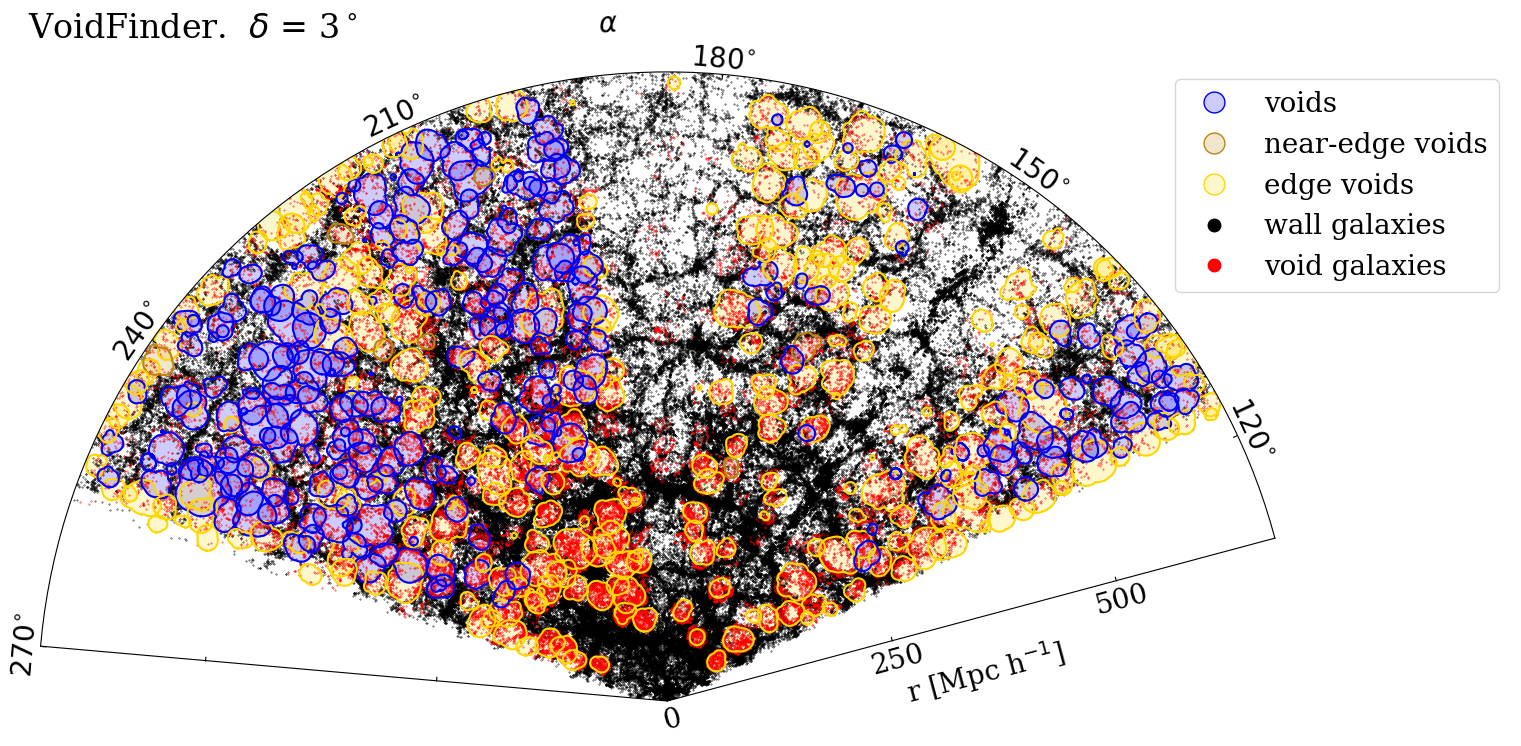

In [28]:

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })


# Parameters: dec, wdth, npc, chkdpth, ra0, ra1, cz0, cz1, title, graph, 
#zlimits, rot, colors, gal_colors, include_gals, include_voids, alpha,
#border_alpha, horiz_legend_offset, plot_sdss, sdss_lim, sdss_color, mag_limit, galaxy_point_size, return_plot_data

graph = voidfinder_slice_plot.plot_survey(3, 10, 1500, 15, 
    110, 270, 0, 0.24, "VoidFinder. ", graph = None, zlimits = True, rot = 265, 
    colors = ['gold','darkgoldenrod','blue'],include_gals=True, include_voids=True, alpha=0.2, border_alpha = 1,
    horiz_legend_offset=0.9,mag_limit=-10, galaxy_point_size=.1, plot_sdss=False)